In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
df_accs = pd.read_csv('Test task for product analyst/ad_systems_accounts.csv')
df_exch_rate = pd.read_csv('Test task for product analyst/exchange_rates.csv')
df_transfers_to_ad = pd.read_csv('Test task for product analyst/transfers_to_ad_systems.csv')
df_user_regs = pd.read_csv('Test task for product analyst/users_registrations.csv')

In [4]:
df_transfers_to_ad['date_payed'] = df_transfers_to_ad['date_payed'].astype('datetime64')

## Сегментация пользователей по сгенерированной выручке

In [5]:
# Сколько платил каждый юзер в млн.
price_sum = df_transfers_to_ad.groupby('user_id')['price'].sum().sort_values(ascending=False) / (10**6)
price_sum = price_sum.to_frame()

In [6]:
price_sum

,price
user_id,
9463,125.346283
259,124.056575
956,117.461151
3891,116.133317
3334,115.753761
...,...
11896,0.099120
6268,0.094156
2207,0.083479


<AxesSubplot:ylabel='Count'>

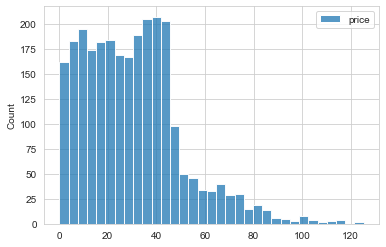

In [7]:
# Исходя из распределения делю на сегменты, с границами в функции segmentation
sns.histplot(data=price_sum)

In [8]:
def segmentation(x):
    if x < 1:
        return 'coal'
    elif x < 16 and x >= 1:
        return 'copper'
    elif x < 32 and x >= 16:
        return 'bronze'
    elif x < 48 and x >= 32:
        return 'silver'
    elif x < 100 and x >= 48:
        return 'gold'
    elif x >= 100:
        return 'platinum'

In [9]:
price_sum['segment'] = price_sum['price'].apply(segmentation)
price_sum = price_sum.reset_index()

In [10]:
# У каждого заплатившего появился сегмент
price_sum

,user_id,price,segment
0,9463,125.346283,platinum
1,259,124.056575,platinum
2,956,117.461151,platinum
3,3891,116.133317,platinum
4,3334,115.753761,platinum
...,...,...,...
2660,11896,0.099120,coal
2661,6268,0.094156,coal
2662,2207,0.083479,coal
2663,3744,0.031192,coal


In [11]:
seg_spread = price_sum['segment'].value_counts().to_frame()

<AxesSubplot:ylabel='segment'>

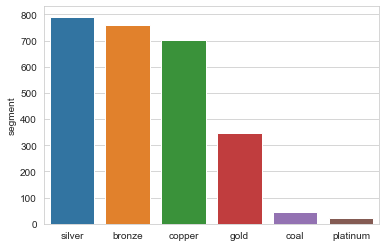

In [12]:
# Распределение сегментов по количеству юзеров
sns.barplot(data=seg_spread, y='segment', x=seg_spread.index)

In [13]:
price_sum.groupby('segment')['price'].sum()

segment
bronze      18222.361998
coal           22.937635
copper       6030.875278
gold        22462.420519
platinum     2390.702998
silver      31334.076640
Name: price, dtype: float64

<AxesSubplot:ylabel='price'>

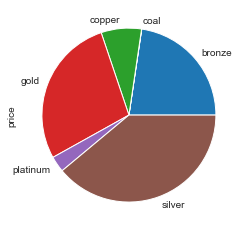

In [14]:
# Распределение пользователей по сегменту по выручке
price_sum.groupby('segment')['price'].sum().plot(kind='pie')

In [15]:
# добавляем сегмент в табличку с юзерами
df_seg_users = df_user_regs.merge(price_sum, how='left', left_on='user_id', right_on='user_id')

In [16]:
# помечаем юзеров которые ни разу не платили 
df_seg_users['segment'] = df_seg_users['segment'].fillna('not paid')

In [17]:
df_seg_users = df_seg_users.sort_values(by='user_id')

In [18]:
# сохраняем в csv для последуюзещего импорта в postgresql.
df_seg_users[['user_id','segment']].to_csv('user_segmnent.csv', index=False)

In [19]:
# видим то как просегментированы юзеры
df_seg_users[['user_id','segment']].head(10)

,user_id,segment
9969,1,not paid
1401,2,silver
13114,3,not paid
2234,4,not paid
3666,5,not paid
1964,6,copper
13115,7,bronze
3386,8,gold
6558,9,copper
12858,10,not paid


### Расчет оттока клиентов (churn rate)

<AxesSubplot:ylabel='Frequency'>

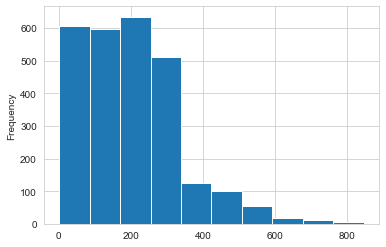

In [20]:
# Распределение юзеров по количеству транзакций переводов
df_transfers_to_ad.groupby('user_id')['date_payed'].count().sort_values(ascending=False).plot(kind='hist')

In [21]:
# Рассчитываем разницу в днях между платежами для всех юзеров
df = df_transfers_to_ad.sort_values(by=['user_id', 'date_payed'])
df['diff'] = df.groupby('user_id')['date_payed'].diff().dt.days
df

,user_id,ad_system,account_id,date_payed,price,currency,diff
196484,2,mytarget,173460,2018-11-17 13:29:12,21032.0,RUB,NaN
452461,2,mytarget,173460,2018-11-17 17:44:58,202659.0,RUB,0.0
516525,2,mytarget,173460,2018-11-18 19:21:54,76491.0,RUB,1.0
271386,2,mytarget,173460,2018-11-19 17:53:26,1962.0,RUB,0.0
346071,2,mytarget,173460,2018-11-20 03:10:16,195548.0,RUB,0.0
...,...,...,...,...,...,...,...
525230,14272,google,169703,2019-06-30 18:15:41,290034.0,RUB,4.0
354758,14272,google,169703,2019-07-01 23:46:09,84664.0,RUB,1.0
2425,14272,google,169703,2019-07-03 03:07:22,250731.0,RUB,1.0
439803,14272,google,169703,2019-07-04 09:13:12,195845.0,RUB,1.0


<AxesSubplot:ylabel='Frequency'>

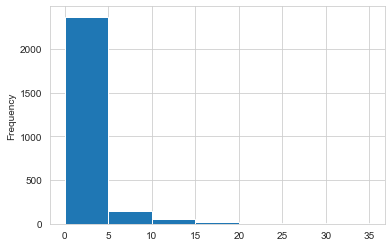

In [22]:
# Усредняем транзакционную частоту в днях по каждому пользователю,
# визуализируем в виде гистрограммы
grouped = df.groupby('user_id')['diff'].mean().sort_values(ascending=False)
grouped.plot(kind='hist', bins=[0, 5, 10, 15, 20, 25, 30, 35])

Видим, что у более чем 2000 (80%)  совершивших платеж пользователей, частота совершения транзаций составляет менее чем 5 дней. Предположим, что если пользователь не совершал транзакции в течении 10 дней - мы его потеряли, фиксируем отток.

In [23]:
# TODO Рассчитать на каждый конкретный день количество ушедших пользователей, количество новых и активных пользователей.